<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline


# from https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
# Supress warnings
import warnings
warnings.filterwarnings('ignore')

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2022-06-04 02:42:55--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.03s   

2022-06-04 02:42:56 (791 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

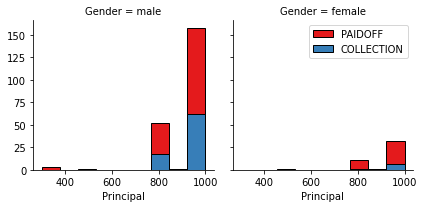

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

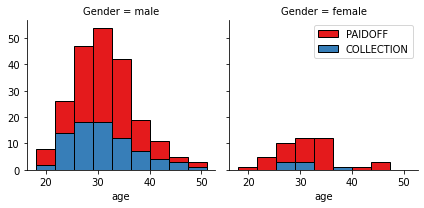

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


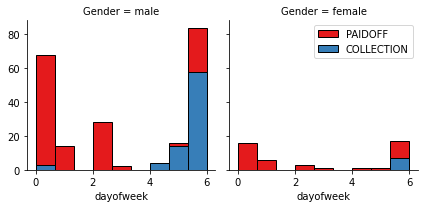

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [17]:
X = Feature
X_raw=Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
y = df['loan_status'].values
y_raw=y
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [19]:
# Done after split
# X= preprocessing.StandardScaler().fit(X).transform(X)
# X[0:5]

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


## Set training set and test set for later uses

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
# Pipline Frame
def NN_model_pipeline(NN,i,X_train,y_train,X_test,y_test,record_list,model_list):
    record_list[i-1][0]=i
    
    #Train Model and Predict  
    model_list.append(NN)
    pre_y_test = NN.predict(X_test)
    pre_y_train = NN.predict(X_train)
    #print("K value: ", i)
    
    # Record train and test score
    trainscore=metrics.accuracy_score(y_train, pre_y_train)
    record_list[i-1][1]=trainscore
    #print("Train set Accuracy: ", trainscore)
    
    testscore=metrics.accuracy_score(y_test, pre_y_test)
    record_list[i-1][2]=testscore
    #print("Test set Accuracy: ", testscore)
    
    # Compute average score
    avgscore=(testscore+trainscore)/2.
    record_list[i-1][3]=avgscore
    #print("Average Accuracy: ", avgscore, "\n")
    
    # Compute score difference
    difscore=abs(testscore-trainscore)
    record_list[i-1][4]=difscore


In [22]:
def NN_pipeline_findbest(score_list):
    # Find max avg
    NN_maxavg=min(score_list[:,3])
    K_index_ma=np.where(score_list[:,3] == NN_maxavg)[0][0]

    # Find min dif
    NN_mindif=min(abs(score_list[:,4]))
    K_index_md=np.where(abs(score_list[:,4]) == NN_mindif)[0][0]
    NN_md_ma=score_list[K_index_md,3]
    
    return [NN_maxavg, K_index_ma, NN_mindif, K_index_md, NN_md_ma]

In [23]:
def NN_pipeline_result(NN_record,bestN_loc,N_max,\
                      number_of_x_ticks,minorticlocation):
    NN_listnames=['Train Acc','Test Acc','Avg Acc','Dif Acc','Best']
# Visualize results to identify the best K taht has best Train and Test 
    NN_plot=plt.axes()

    NN_plot.plot(NN_record[:,0],NN_record[:,1],\
                  color='r',label=NN_listnames[0],linestyle='--')
    NN_plot.plot(NN_record[:,0],NN_record[:,2],\
                  color='b',label=NN_listnames[1],linestyle='--')
    NN_plot.plot(NN_record[:,0],NN_record[:,3],\
                  color='g',label=NN_listnames[2])

    # Secondary y axes
    NN_resi_plot=NN_plot.twinx()
    NN_resi_plot.plot(NN_record[:,0],NN_record[:,4],\
                  color='y',label=NN_listnames[3])
    NN_resi_plot.plot([bestN_loc+1,bestN_loc+1],[0,1],\
                          color='k',label=NN_listnames[4],linestyle=':')

    # Set figure configurations
    #KNN_plot.rcParams["figure.autolayout"] = True
    NN_plot.set_xlabel('N number')
    NN_plot.set_ylabel('Accuracy')
    NN_plot.legend(NN_listnames[0:3], bbox_to_anchor=(0.2, 0.5, 0.5, 0.5))

    NN_resi_plot.set_ylabel('Accuracy Difference')

    NN_resi_plot.legend(NN_listnames[3:5],loc='upper right')

    xticks_major_locators=list(np.arange(0, N_max, step=(N_max-0)/number_of_x_ticks))
    xticks_minor_locators=list(np.arange(0, N_max, \
                     step=(N_max-0)/number_of_x_ticks/minorticlocation))

    NN_plot.xaxis.set_major_locator(mtplt.ticker.FixedLocator(xticks_major_locators))
    NN_plot.xaxis.set_minor_locator(mtplt.ticker.FixedLocator(xticks_minor_locators))
    NN_plot.set_xlim([0, N_max])
    NN_resi_plot.set_ylim([0, max(NN_record[:,4])*1.1])

    print("Best identified is:", bestN_loc+1, \
          "\nWith average accuracy of", "{:.3f}".format(NN_record[bestN_loc,3]), \
         "\nAnd accuracy difference of", "{:.3f}".format(NN_record[bestN_loc,4]))
    
    return bestN_loc

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import scipy.optimize as opt

In [25]:
# From Previous Lab
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [26]:
# Import neccesary modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib as mtplt


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [28]:
# Normalizing traing and test set
X_train= preprocessing.StandardScaler().fit(X_train).transform(X_train)
X_test= preprocessing.StandardScaler().fit(X_test).transform(X_test)

In [29]:
# Pipeline K to investigate
k_min=1
k_max=20

# Setup storage for trained models and model outputs
KNN_outputmodels=[]
KNN_outputmodel_evals=np.zeros((k_max,5))

for i in range(k_min, k_max+1, 1):    
    NN = KNeighborsClassifier(n_neighbors = i)
    NN.fit(X_train,y_train)
    NN_model_pipeline(NN,i,X_train,y_train,X_test,y_test,\
                      KNN_outputmodel_evals,KNN_outputmodels)
    

In [30]:
Find_best_result_KNN=NN_pipeline_findbest(KNN_outputmodel_evals)

Best identified is: 8 
With average accuracy of 0.772 
And accuracy difference of 0.058


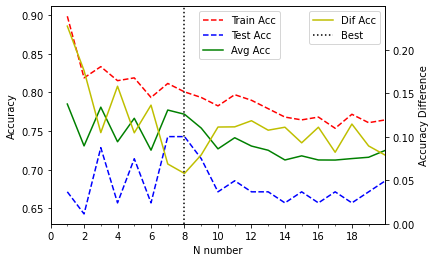

In [31]:
number_of_x_ticks=10
minorticlocation=2
# Find plotting function defined at top
NN_pipeline_result(KNN_outputmodel_evals,Find_best_result_KNN[3],k_max,\
                      number_of_x_ticks,minorticlocation)
Best_model_KNN=KNN_outputmodels[Find_best_result_KNN[3]]

# Decision Tree


In [32]:
import sys
import sklearn
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree


In [33]:
# Since values are numerical, it can be used to perform simulation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
print ('Train set:', X_train.shape,  y_train.shape)
#print(X_train[0:5])
print ('Test set:', X_test.shape,  y_test.shape)


Train set: (242, 8) (242,)
Test set: (104, 8) (104,)


In [34]:
# Pipeline K to investigate
max_depth_min=1
max_depth_max=20

# Setup storage for trained models and model outputs
Tre_outputmodels=[]
Tre_outputmodel_evals=np.zeros((max_depth_max,5))

for i in range(max_depth_min, max_depth_max+1, 1):    
    NN = DecisionTreeClassifier(criterion="entropy", max_depth = i)
    NN.fit(X_train,y_train)
    NN_model_pipeline(NN,i,X_train,y_train,X_test,y_test,\
                      Tre_outputmodel_evals,Tre_outputmodels)


In [35]:
# Notice: You might need to uncomment and install the pydotplus and graphviz libraries if you have not installed these before
# !conda install -c conda-forge pydotplus -y
# !conda install -c conda-forge python-graphviz -y

# conda update conda
# !pip install --upgrade scikit-learn


#Tree plot only work for scikit-learn > 0.21, change auto_update to 0 if you don't want it
auto_update=1
if float(sklearn.__version__[2:]) < 23:
    if auto_update==1:
        # Run if you need to upgrade
        !pip install --upgrade scikit-learn==0.23.1
        import sklearn
        from sklearn.tree import DecisionTreeClassifier
        import sklearn.tree as tree
    else:
        sys.exit("Scikit-Learn version insufficient to plot tree")
    
    

In [36]:
Find_best_result_Tree=NN_pipeline_findbest(Tre_outputmodel_evals)

Best identified is: 1 
With average accuracy of 0.748 
And accuracy difference of 0.016


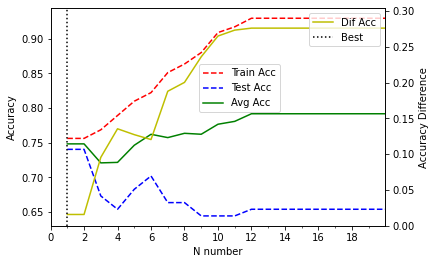

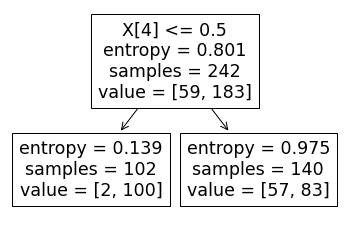

In [37]:
number_of_x_ticks=10
minorticlocation=2
# Find plotting function defined at top
NN_pipeline_result(Tre_outputmodel_evals,Find_best_result_Tree[3],k_max,\
                      number_of_x_ticks,minorticlocation)
plt.show()
# Plot the tree
tree.plot_tree(Tre_outputmodels[Find_best_result_Tree[3]])
plt.show()


Best_model_TREE=Tre_outputmodels[Find_best_result_Tree[3]]



# Support Vector Machine


In [38]:
from sklearn import svm

In [39]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (242, 8) (242,)
Test set: (104, 8) (104,)


In [40]:
# Normalizing traing and test set
X_train= preprocessing.StandardScaler().fit(X_train).transform(X_train)
X_test= preprocessing.StandardScaler().fit(X_test).transform(X_test)

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        27
     PAIDOFF       0.74      1.00      0.85        77

    accuracy                           0.74       104
   macro avg       0.37      0.50      0.43       104
weighted avg       0.55      0.74      0.63       104

['linear', 'rbf', 'sigmoid'] : Results
Confusion matrix, without normalization
[[77  0]
 [27  0]]


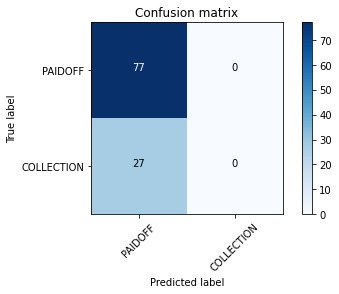


F1 Score is:  0.630
Jaccard Score is:  0.740
              precision    recall  f1-score   support

  COLLECTION       1.00      0.04      0.07        27
     PAIDOFF       0.75      1.00      0.86        77

    accuracy                           0.75       104
   macro avg       0.87      0.52      0.46       104
weighted avg       0.81      0.75      0.65       104

['linear', 'rbf', 'sigmoid'] : Results
Confusion matrix, without normalization
[[77  0]
 [26  1]]


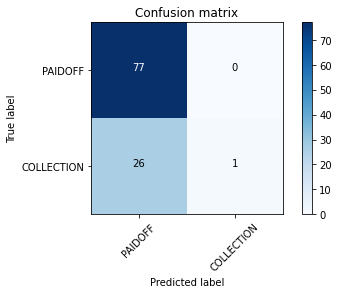


F1 Score is:  0.652
Jaccard Score is:  0.748
              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        27
     PAIDOFF       0.73      0.94      0.82        77

    accuracy                           0.69       104
   macro avg       0.36      0.47      0.41       104
weighted avg       0.54      0.69      0.61       104

['linear', 'rbf', 'sigmoid'] : Results
Confusion matrix, without normalization
[[72  5]
 [27  0]]


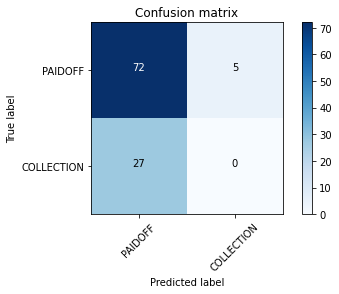


F1 Score is:  0.606
Jaccard Score is:  0.692


In [41]:
# Loop through all models, somehow all predict 100% paidoff...
modellists=['linear','rbf','sigmoid']
# 'poly' takes fore
for modelitems in modellists:
    clf = svm.SVC(kernel=modelitems)
    clf.fit(X_train, y_train) 
    
    if modelitems==modellists[1]:
        Best_model_SVM=clf
    
    yhat = clf.predict(X_test)
    datalabels_SVM=['PAIDOFF','COLLECTION']

    cnf_matrix = confusion_matrix(y_test, yhat, labels=datalabels_SVM)
    np.set_printoptions()

    print (classification_report(y_test, yhat))
    print(modellists, ": Results")
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=datalabels_SVM,normalize= False,  title='Confusion matrix')
    plt.show()
    from sklearn.metrics import f1_score
    print("\nF1 Score is: ", "{:.3f}".format(f1_score(y_test, yhat, average='weighted')))

    from sklearn.metrics import jaccard_score
    print("Jaccard Score is: ", "{:.3f}".format(jaccard_score(y_test, yhat,pos_label=datalabels_SVM[0])))
    


# Logistic Regression


In [42]:
from sklearn.linear_model import LogisticRegression

In [43]:
# Convert PAIDOFF to 1 and COLLECTION to 0
y_converted_numerical=np.zeros([len(df['loan_status']),1])
for i in range(0,len(df['loan_status']),1):
    value=df['loan_status'][i]
    if value == 'PAIDOFF':
        y_converted_numerical[i]=1
    else:
        y_converted_numerical[i]=0

In [44]:
X_normed = preprocessing.StandardScaler().fit(X).transform(X)
X_normed[0:3]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679]])

In [45]:
X_train, X_test, y_train, y_test = train_test_split( X_normed, y_converted_numerical, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276, 1)
Test set: (70, 8) (70, 1)


In [46]:
# Train model
Loan_LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
Best_model_LR=Loan_LR

In [47]:
Predict_LR = Loan_LR.predict(X_test)
Predict_Pron_LR = Loan_LR.predict_proba(X_test)
LR_cnf_matrix = confusion_matrix(y_test, Predict_LR, labels=[1,0])

Confusion matrix, without normalization
[[46  9]
 [13  2]]


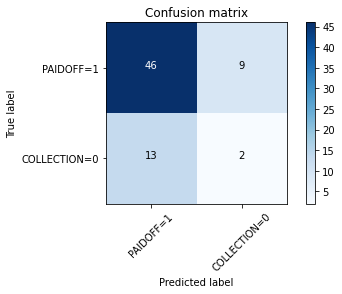

In [48]:
plot_confusion_matrix(LR_cnf_matrix, classes=['PAIDOFF=1','COLLECTION=0'],\
                      normalize= False,  title='Confusion matrix')


In [49]:
from sklearn.metrics import log_loss
log_loss(y_test, Predict_Pron_LR)

0.5772287609479654

# Model Evaluation using Test set


In [50]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [51]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-06-04 02:43:01--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0.001s  

2022-06-04 02:43:01 (3.72 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [52]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [53]:
y_model_test=test_df['loan_status'].values
y_model_test[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [54]:
# Convert loan status to numerical for logistic to compare
y_converted_numerical_test=np.zeros([len(test_df['loan_status']),1])
for i in range(0,len(test_df['loan_status']),1):
    value=test_df['loan_status'][i]
    if value == 'PAIDOFF':
        y_converted_numerical_test[i]=1
    else:
        y_converted_numerical_test[i]=0

In [55]:
# Formulate the input data
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)


In [56]:
# Formulate the input data as workbook defined
Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [57]:
normed_X=preprocessing.StandardScaler().fit(Feature_test).transform(Feature_test)

In [58]:
# Template for report
def report_values_best_model(model,input_features,y_test,model_name):
    yhat=model.predict(input_features)
    result_f1_score=f1_score(y_test, yhat, average='weighted')
    result_accard_score=jaccard_score(y_test, yhat, pos_label='PAIDOFF')
    results=[model_name,result_f1_score, result_accard_score, 'N/A']
    return results

In [59]:
# Report KNN
KNN_results=report_values_best_model(Best_model_KNN,normed_X,y_model_test,'KNN')

In [60]:
# Report Tree
TREE_results=report_values_best_model(Best_model_TREE,Feature_test,y_model_test,'Decision Tree')

In [61]:
# Report SVM
SVM_results=report_values_best_model(Best_model_SVM,normed_X,y_model_test,'SVM')

In [62]:
# Predict LR and convert reults back to objects
LR_predict=Best_model_LR.predict(normed_X)
LR_predict_object=[]
for item in LR_predict:
    if item == 1.:
        LR_predict_object.append('PAIDOFF')
    else:
        LR_predict_object.append('COLLECTION')
        


In [63]:
# Get report values
LR_f1_score=f1_score(y_model_test, LR_predict_object, average='weighted')
LR_jaccard_score=jaccard_score(y_model_test, LR_predict_object, pos_label='PAIDOFF')
LR_LL=log_loss(y_converted_numerical_test, Best_model_LR.predict_proba(normed_X))
LR_results=['LogisticRegression',LR_f1_score,LR_jaccard_score,LR_LL]

In [64]:
overtall_report=[KNN_results,TREE_results,SVM_results,LR_results]

# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


In [65]:
# Round to 3 digits

reportdf=pd.DataFrame(overtall_report,columns=['Algorithm','Jaccard','F1-score','LogLoss'])
display(reportdf.round(2))


,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.71,0.66,N/A
1,Decision Tree,0.63,0.74,N/A
2,SVM,0.62,0.72,N/A
3,LogisticRegression,0.66,0.74,0.567215


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2022-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
